#PyFiniteDifferences - Zone plate

##Imports
This is where the necessary libraries are imported. Note that we import sympy and the finite difference symbols into the local namespace.

In [335]:
from sympy import *
from pyfinitedifferences.symbols import *
from pyfinitedifferences.compile_sympy import Array 
from pyfinitedifferences import finitedifferences
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
%matplotlib inline
init_printing(use_latex='mathjax')

##Units
This will allow us to use Units in simulation parameters. Here, units are imported into the namespace *u*.

In [336]:
import sympy.physics.units as u
u.keV = 1000 * u.eV

##Symbols
Necessary symbols for constants and variables are defined here for later use. Note the use of latex in the variable names for typesetting.

In [337]:
n_Ta = Symbol("n_\mathrm{Ta}") 
n_Va = Symbol("n_\mathrm{Va}")
n_Zr = Symbol("n_\mathrm{Zr}")
n_X  = Symbol("n_\mathrm{x}")

E    = Symbol("E",real=True,positive=True)
hbar = Symbol(r"\hslash",real=True)
c    = Symbol("c",real=True)

r_zoneplate  = Symbol("r_\mathrm{Zoneplate}",real=True,positive=True)
n_zoneplate  = Symbol("n_\mathrm{Zoneplate}",integer=True)
n_zoneplate_one  = Symbol("n_\mathrm{Zoneplate_{one}}",complex=True)
n_zoneplate_two  = Symbol("n_\mathrm{Zoneplate_{two}}",complex=True)
n_zoneplate_three= Symbol("n_\mathrm{Zoneplate_{three}}",complex=True)
N_zoneplate  = Symbol("N_\mathrm{Zoneplate}",integer=True)
d_zoneplate  = Symbol("d_\mathrm{Zoneplate}",real=True,positive=True)
f_zoneplate  = Symbol("f_\mathrm{Zoneplate}",real=True)
z_zoneplate  = Symbol("z_\mathrm{Zoneplate}",real=True)



##Settings
The simulation parameters are stored in this object.

In [338]:
settings = finitedifferences.Settings()

##Solve the parabolic wave equation
We will use the [Crank–Nicolson method](http://en.wikipedia.org/wiki/Crank–Nicolson_method) to numerically solve the parabolic wave equation:

$$
\frac{\partial u}{\partial z} = A \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) + F(x,y,z) u, 
$$

with $F(x,y,z)$ and $A$ defined as below.

In [339]:
settings[F] = -I*k/2*(n**2-1);
settings[A] = -I/(2*k);        

display.display(Eq(F,settings[F]))
display.display(Eq(A,settings[A]))

                  ⎛ 2             ⎞ 
             -i⋅k⋅⎝n (x, y, z) - 1⎠ 
F(x, y, z) = ───────────────────────
                        2           

    -i 
A = ───
    2⋅k

##Wave number
We will define the the wavenumber $k$ through the wave energy and set the numeric values for $\hbar$ and $c$.

In [340]:
settings.numeric_values[hbar] = u.hbar
settings.numeric_values[c]    = u.c
settings[k] = E / (hbar*c)

display.display(Eq(k,settings[k]))

        E    
k = ─────────
    \hslash⋅c

##Zone radii

In [341]:
def r_zoneplate(n_zoneplate,wavelength = wavelength,f_zoneplate=f_zoneplate):
    return (n_zoneplate*wavelength*f_zoneplate + n_zoneplate**2*wavelength**2 / 4)**0.5
display.display(Eq(Function("r_\mathrm{Zone plate}")(n_zoneplate),r_zoneplate(n_zoneplate)))

                                                                              
                                              ⎛       2                     2 
                                              ⎜\lambda ⋅n_\mathrm{Zoneplate}  
r_\mathrm{Zone plate}(n_\mathrm{Zoneplate}) = ⎜────────────────────────────── 
                                              ⎝              4                

                                                    0.5
                                                   ⎞   
                                                   ⎟   
+ \lambda⋅f_\mathrm{Zoneplate}⋅n_\mathrm{Zoneplate}⎟   
                                                   ⎠   

##Simulation box
The simulation box is defined using $n_x \cdot n_y \cdot n_z$ voxels in $x$, $y$ and $z$ direction (propagation direction is $z$).

In [342]:
settings.update({
    sx:16.384*u.um,
    sy:sx,
    sz:2.6*u.um, #2*f_zoneplate  
})
step_size = sx/nx
settings.numeric_values.update({
        nx:16384,
        ny:nx,
        nz:260,
})

settings.length_unit = 'um'
#settings.numeric_values[u.m] = u.m/u.um
settings.numeric_values[u.m] = u.m/u.um


##Numeric values
Numeric values for the simulation are set.

In [343]:
settings.numeric_values.update({
    n_Ta: 1,#1-4.3941E-05-I*2.8617E-06,
    n_Zr: 1-I*1E-03,#1-1.2956E-05-I*1.7834E-06,    
    n_Va: 1,
    n_X:  1-I*1E-03,
        
    E: 7.9*u.keV,
    
     
    N_zoneplate:50,#784,
    n_zoneplate_one: n_X,
    n_zoneplate_two: n_Ta,
    n_zoneplate_three: n_Zr,    
    f_zoneplate:500*u.um,
    d_zoneplate:2.6*u.um,
        
    z_zoneplate:0
})

In [344]:
display.display(settings.get(dx, float))

0.001

##Refractive index

We use the formula for the radii to create an array to store the zones (where an element corresponds to the distance in $dx$ units). The array is defined as 
$$
\text{zoneplate}[n] = \begin{cases} 1, & \text{if $x = n \cdot dx $ is inside a zone} \\ 0, & \text{otherwise,} \end{cases}
$$
for a zoneplate with $N_\text{zoneplate}$ zones.

In [345]:
zoneplate_array = np.zeros(settings.get(nx/2,int),dtype=np.int)

ro = 0
n_wavelength = settings.get(wavelength,float)
n_f_zoneplate = settings.get(f_zoneplate,float)
n_dx = settings.get(dx,float)
n_first = 10
n_first_config = n_first - 1


#for ni in range(n_first-1):
#    rx = int(r_zoneplate(ni,n_wavelength,n_f_zoneplate)/n_dx + 0.5) # definiert den Glas kern

for ni in range(0,settings.get(N_zoneplate,int)):
    if ni<n_first_config:
        rx = int(r_zoneplate(ni,n_wavelength,n_f_zoneplate)/n_dx + 0.5) # definiert den Glas kern
        zoneplate_array[0:rx]   = 1*(np.ones(rx,dtype=np.int))
    else:
        ri = int(r_zoneplate(ni-1,n_wavelength,n_f_zoneplate)/n_dx + 0.5) # round to nearest integer, defineirt Material Ta
        rj = int(r_zoneplate(ni,n_wavelength,n_f_zoneplate)/n_dx + 0.5) # definiert Material Zr        
        if ni%2==0: #gerade
            zoneplate_array[ri:rj]  = 2*(np.ones(rj-ri,dtype=np.int))
        if ni%2!=0: #ungerade
            zoneplate_array[ri:rj]  = 3*(np.ones(rj-ri,dtype=np.int))        
        #display.display(rj-ri)
        
        
    
zoneplate_function = Array("zoneplate",zoneplate_array)

inside_zoneplate_r_one   = Eq(zoneplate_function(floor(sqrt(x**2+y**2)/dx + 0.5)),1)
inside_zoneplate_r_two   = Eq(zoneplate_function(floor(sqrt(x**2+y**2)/dx + 0.5)),2)
inside_zoneplate_r_three = Eq(zoneplate_function(floor(sqrt(x**2+y**2)/dx + 0.5)),3)
inside_zoneplate_z = abs(z - z_zoneplate) <= d_zoneplate/2

settings[n] = Piecewise((n_zoneplate_one,inside_zoneplate_r_one & inside_zoneplate_z),(n_zoneplate_two,inside_zoneplate_r_two & inside_zoneplate_z),(n_zoneplate_three,inside_zoneplate_r_three & inside_zoneplate_z),(n_Va,True))

display.display(settings[n])

⎧                                           ⎛⎢         _________⎥⎞            
⎪                                           ⎜⎢        ╱  2    2 ⎥⎟            
⎪                                           ⎜⎢      ╲╱  x  + y  ⎥⎟            
⎪ n_\mathrm{Zoneplate_{one}}   for zoneplate⎜⎢0.5 + ────────────⎥⎟ = 1 ∧ │z - 
⎪                                           ⎝⎣           dₓ     ⎦⎠            
⎪                                                                             
⎪                                           ⎛⎢         _________⎥⎞            
⎪                                           ⎜⎢        ╱  2    2 ⎥⎟            
⎪                                           ⎜⎢      ╲╱  x  + y  ⎥⎟            
⎨ n_\mathrm{Zoneplate_{two}}   for zoneplate⎜⎢0.5 + ────────────⎥⎟ = 2 ∧ │z - 
⎪                                           ⎝⎣           dₓ     ⎦⎠            
⎪                                                                             
⎪                                           ⎛⎢      

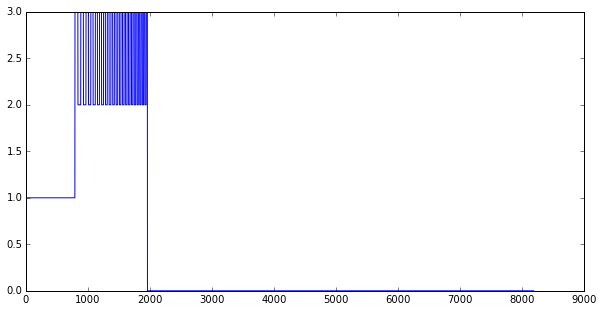

In [346]:
plt.figure(figsize=(10,5))
plt.plot(abs(zoneplate_array))
plt.show()

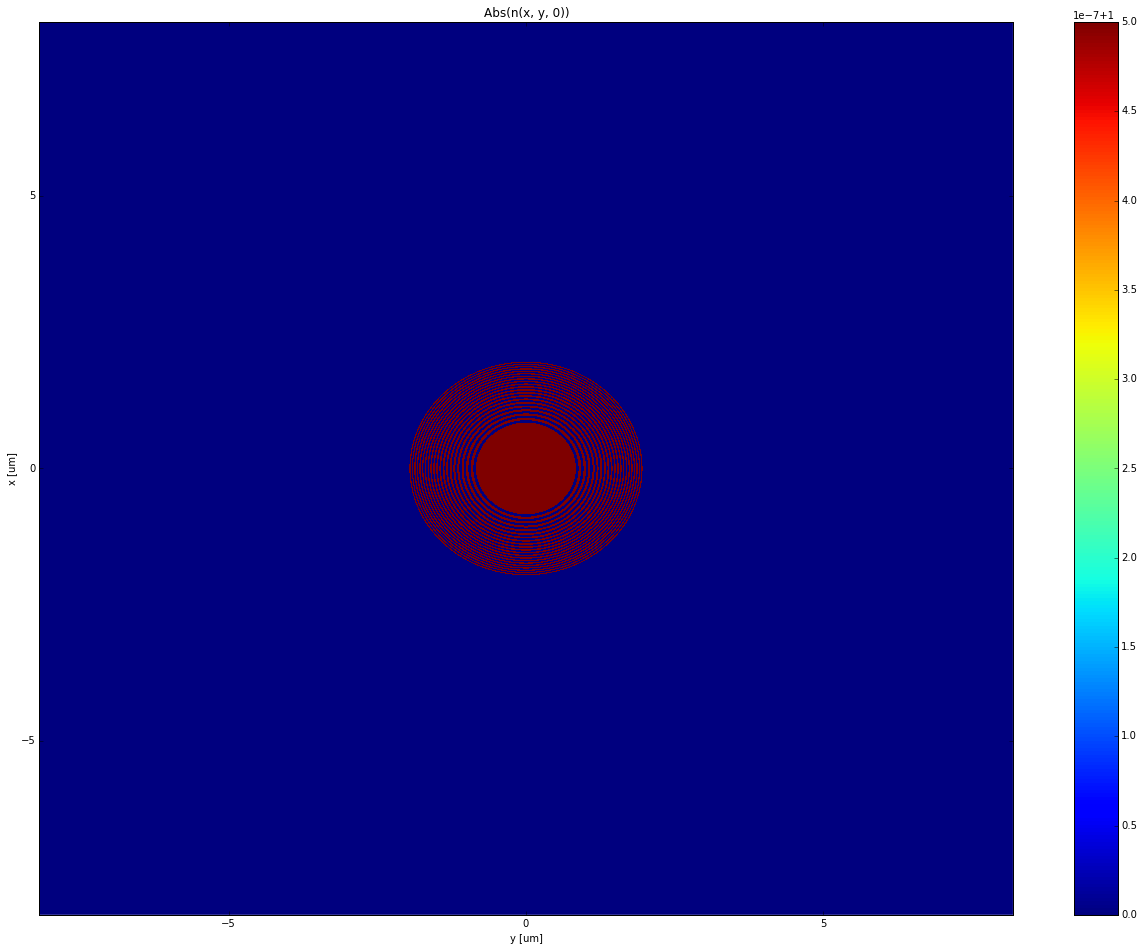

In [347]:
plt.figure(figsize=(48,16))
plt.subplot(121)
finitedifferences.plot_front(abs(n),settings,show=False,z0=settings.get(z_zoneplate,numeric=True))

#plt.subplot(122)
#finitedifferences.plot_side(abs(n),settings )


##Boundary conditions
Now boundary conditions are defined. $u_0(x,y)$ is the field at $z=z_0$, while $u_{0\mathrm{Boundary}}(x,y,z)$ is the field at the simulation box edges ($x = \pm s_x/2 \lor y = \pm s_y/2$).

In [348]:
w0 = 10*u.um                              #Strahlgröße im Fokus
zR = (math.pi*w0**2)/wavelength

#pre_z = (wavelength*f_zoneplate/(math.pi*w0**2))
w = w0 #* sqrt(1+pre_z**2)
Rinv = 0#(f_zoneplate*(1+(zR/f_zoneplate)**2))**-1

r = x
settings[u0] = 1 * exp((-r**2)/(w**2))#*exp(-(2*math.pi/wavelength)*(I*r**2*Rinv/2))

settings[u0_boundary] = 0
#display.display(settings.get_x_values())


##Finite difference solver 1D
Create the solver using the settings and run a 1D simulation.

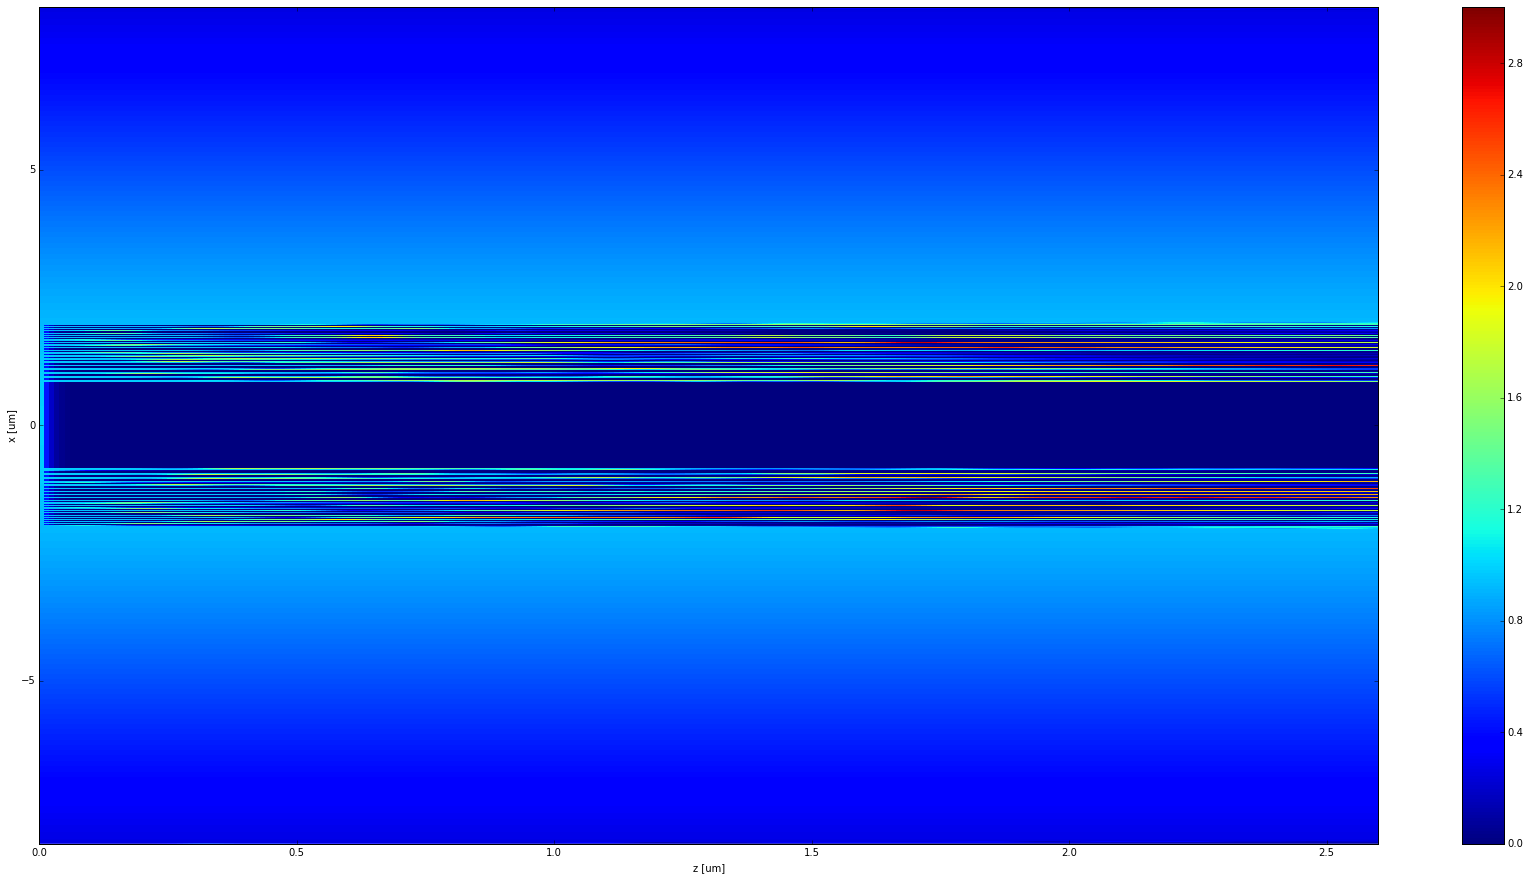

3.00297434175

In [349]:
solver_1D = finitedifferences.Solver1D(settings)
data_1D = solver_1D.run()
finitedifferences.plot_side(np.abs(data_1D)**2,settings,size=(30,15))
display.display(np.amax((np.abs(data_1D)**2)))


In [350]:
intensity_beginning_1 = 0
intensity_beginning_2 = 0
total_intensity_beginning = 0

xi0 = settings.get_x_index(0)

xi1 = settings.get(nx, int)/2+round(settings.get((r_zoneplate(n_first)/step_size), float))
xi2 = settings.get(nx, int)/2+round(settings.get((r_zoneplate(N_zoneplate)/step_size), float))

xi3 = settings.get(nx, int)/2-round(settings.get((r_zoneplate(n_first)/step_size), float))
xi4 = settings.get(nx, int)/2-round(settings.get((r_zoneplate(N_zoneplate)/step_size), float))

xi5 = float(settings.get_x_index(0)+5)
xi6 = float(settings.get_x_index(0)-5)

test1 = xi1
test2 = xi2

zi1 = settings.get_z_index(z_zoneplate + f_zoneplate - 50)
zi2 = settings.get_z_index(z_zoneplate + f_zoneplate + 50)

zf1 = round(settings.get(((d_zoneplate/dz)), float))
#zf3 = float(zi1+np.argmax((np.abs(data_1D[xi0,zi1:zi2])**2)))


intensity_beginning_1 = np.sum(np.abs(data_1D[xi1:xi2,0])**2)
intensity_beginning_2 = np.sum(np.abs(data_1D[xi4:xi3,0])**2)

intensity_end_1 =   np.sum(np.abs(data_1D[xi1:xi2,zf1])**2)
intensity_end_2 =   np.sum(np.abs(data_1D[xi4:xi3,zf1])**2)

#intensity_focus_1 = np.sum(np.abs(data_1D[xi6:xi5,zf3])**2)


steps = (xi2+xi3)-(xi1+xi4)

total_intensity_beginning = np.abs((intensity_beginning_1 + intensity_beginning_2))
total_intensity_end = np.abs((intensity_end_1 + intensity_end_2))
#total_intensity_focus = np.abs((intensity_focus_1))


display.display(steps)
display.display((total_intensity_beginning))
display.display((total_intensity_end))
#display.display((total_intensity_focus))
#display.display((total_intensity_focus/total_intensity_beginning))



2190.0

2097.97021817

973.940500171

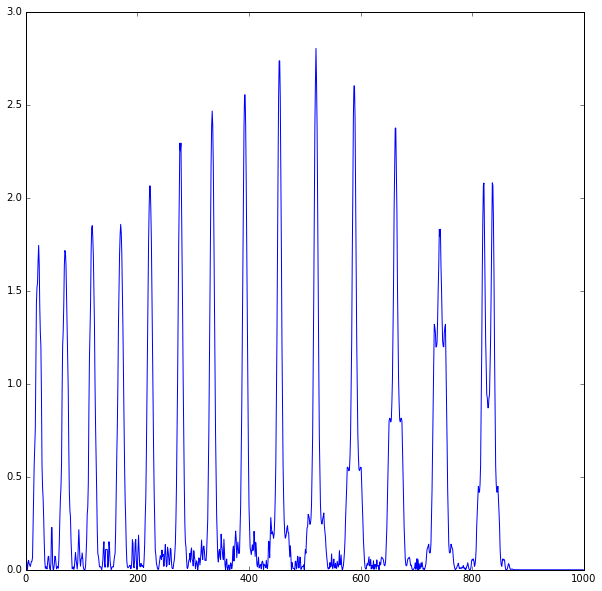

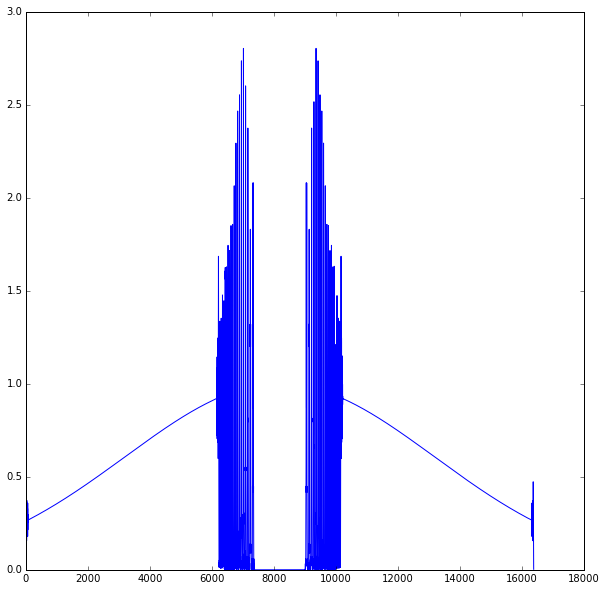

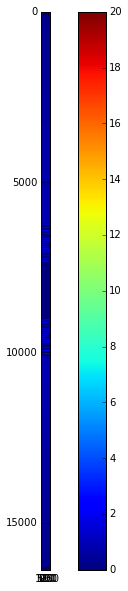

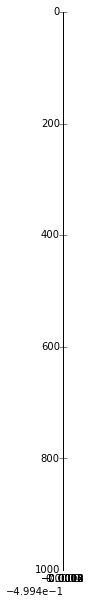

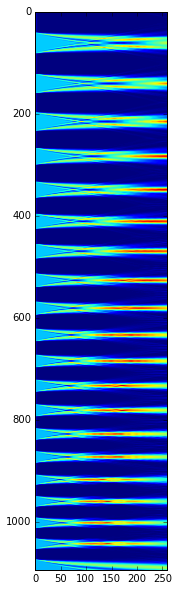

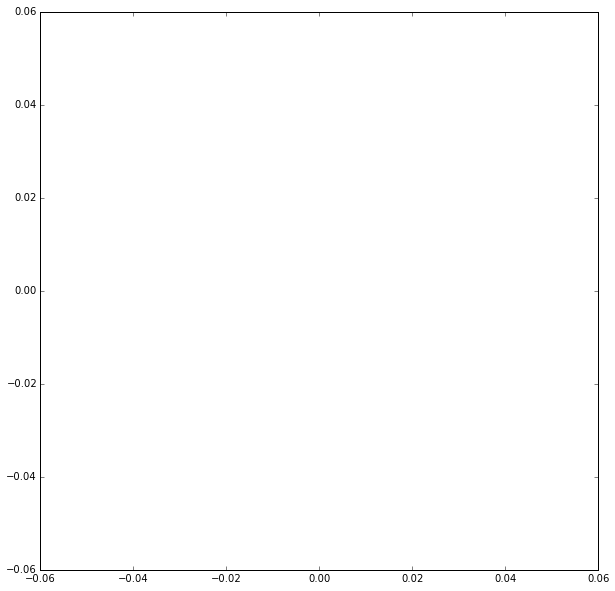

In [351]:
xi1 = settings.get_x_index(-0.5)
xi2 = settings.get_x_index(+0.5)
xi3 = settings.get_x_index(0)

#zi3 = zf3


#display.display(np.amax(np.abs(data_1D[xi1:xi2,zi1:zi2])**2))
#display.display((np.amax(np.abs(data_1D[xi3,zi3])**2)))

plt.figure(figsize=(10,10))
plt.plot(np.abs(data_1D[6500:7500,260])**2)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(np.abs(data_1D[0:16384,260])**2)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.abs(data_1D**2))
plt.clim([0,20])
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.abs(data_1D[xi1:xi2,zi1:zi2])**2)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.abs(data_1D[test1:test2,0:zf1])**2)
plt.show()

#plt.figure(figsize=(10,10))
#plt.plot(np.abs(data_1D[xi1:xi2,zi3])**2)
#plt.show()

plt.figure(figsize=(10,10))
plt.plot(np.abs(data_1D[xi3,zi1:zi2])**2)
plt.show()



As visualized by the plot below we have to simulate in a very high resultion since the spaces between the zones act as small waveguides.

##Finite difference solver 2D
Create the solver using the settings and run a 2D simulation. When calling Solver2D.run() be sure to have enough memory available as this will create a 3-Dimensional complex array of size $n_x \cdot n_y \cdot (n_z/\mathrm{downscale}+1) / \mathrm{downscale}^2$. Otherwise we could run the simulation manually using the Solver2D.step() and Solver2D.get_field() methods. We integrate the intensity along the y-axis and plot the field.

settings.downscale = 1

solver = finitedifferences.Solver2D(settings)
data = solver.run()
finitedifferences.plot_side(np.sum(np.abs(data)**2,axis=1),settings,size=(10,5))

We plot the field intesity in $x$ and $y$ direction at the focal point $z = z_\text{Zoneplate} + f_\text{Zoneplate}$.

finitedifferences.plot_front(np.abs(data[:,:,settings.get_z_index((z_zoneplate + f_zoneplate))])**2,settings,size=(12,10))

We plot the intensity distribution at $x,y=0$ as a function of $z$.

plt.plot(settings.get_z_values(), np.abs(data[settings.get_x_index(0),settings.get_y_index(0),:])**2)
plt.xlabel("$z$[%s]" % settings.length_unit)
plt.ylabel("$I / I_0$")
plt.show()

##3D Visualization
Since we collected 3-Dimensional data we can use vtk to show a volumetric plot of the data (this will probably only work if run on the local machine since opengl context cannot be created without X11 on linux).

import pyfinitedifferences.render
import vtk

n_volume = pyfinitedifferences.render.create_vtk_volume(np.abs(finitedifferences.create_volume_data(n,settings)-1),alpha = 0.005,color=(1,0,0))
u_volume = pyfinitedifferences.render.create_vtk_volume(np.abs(data-1)**2)

Under linux the image might be cropped (interactive works however).

VtkRenderer = vtk.vtkRenderer()
VtkRenderer.SetBackground(1.0, 1.0, 1.0)
VtkRenderer.AddActor(u_volume)
VtkRenderer.AddActor(n_volume)

transform = vtk.vtkTransform()
transform.Translate(1.0, 0.0, 0.0)

pyfinitedifferences.render.vtk_show(VtkRenderer,size=(800,600))

Show an interactive volumetric plot (note that the window may appear in background).

import pyfinitedifferences.render
import vtk

renderer = vtk.vtkRenderer()
renderer.SetBackground(1.0, 1.0, 1.0)
    
renderWin = vtk.vtkRenderWindow()
renderWin.AddRenderer(renderer)
renderInteractor = vtk.vtkRenderWindowInteractor()
renderInteractor.SetRenderWindow(renderWin)

# We add the volume to the renderer ...
renderer.AddVolume(u_volume)
renderer.AddVolume(n_volume)

# ... set background color to white ...
renderer.SetBackground(1, 1, 1)
# ... and set window size.
renderWin.SetSize(800, 600)
    
# A simple function to be called when the user decides to quit the application.
def exitCheck(obj, event):
    if obj.GetEventPending() != 0:
        obj.SetAbortRender(1)

# Tell the application to use the function as an exit check.
renderWin.AddObserver("AbortCheckEvent", exitCheck)

renderInteractor.Initialize()
# Because nothing will be rendered without any input, we order the first render manually before control is handed over to the main-loop.
renderWin.Render()
renderInteractor.Start()
